In [1]:
# unit test
import unittest

from PIL import Image, ImageDraw
import scipy.io
import skimage.io
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

import math

# "helper" needs to be part of sys path
import sys
sys.path.insert(0, "helper")
sys.path.insert(0, "/helper")
sys.path.insert(0, "./helper")
sys.path.insert(0, "../helper")
print(sys.path)

%load_ext autoreload
%autoreload 2

# own module
from data.meanteacher import MeanTeacherTrainDataset, MeanTeacherValDataset
from data.octa500 import *

['../helper', './helper', '/helper', 'helper', 'C:\\Users\\Prinzessin\\projects\\decentnet\\datasceyence\\examples', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\python39.zip', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\DLLs', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta', '', 'C:\\Users\\Prinzessin\\AppData\\Roaming\\Python\\Python39\\site-packages', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\win32', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\win32\\lib', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\Pythonwin', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Prinzessin\\.ipython']


# OCTA500

In [14]:
import torch
from torch.utils.data import Dataset     
import torchvision # from torchvision import datasets, transforms
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

from data.template import TemplateDataLoaderWrapper, TemplateDataset
from data.flattening import *

    

INFO = {
    "octa500": {
        "python_class": "OCTA500",
        "description": "The OCTA500 is based on optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the dataset with a ratio of n:n:n into training, validation and testset",
        "task": "multi-class",
        "label": {
            "0": "choroidal neovascularization", # cnv + amd?
            "1": "diabetic retinopathy", # dr
            "2": "amd", # amd
            "3": "normal", # normal
        },
        "n_channels": 1,
        "n_samples": {"train": 0, "val": 0, "test": 0},
    }
}

path = "data_prep/data_octa_500.csv"

class DataLoaderOCTA500(TemplateDataLoaderWrapper):
    def __init__(self, train_kwargs, model_kwargs):
        
        # transforms
        self.transforms = torchvision.transforms.Compose(self.get_transforms(train_kwargs))
        
        trainset = None # OCTA500Dataset(split="train", transform=self.transforms, download=True)
        valset = None #  OCTA500Dataset(split="val", transform=self.transforms, download=True)
        testset = OCTA500Dataset(mode="test", transforms=self.transforms, index_col=None, channels=1, image_size=train_kwargs["img_size"], csv_filenames=train_kwargs["input_data_csv"], p_aug=0.5) 
        
        self.info = INFO['octa500']
        model_kwargs['n_classes'] = len(self.info['label'])

        # indices for splitting and/or reducing data
        train_indices = None # range(train_kwargs["train_size"])
        val_indices = None # range(train_kwargs["val_size"])
        test_indices = range(train_kwargs["test_size"])
        
        # from parent
        self.set_data(train_indices=train_indices, val_indices=val_indices, test_indices=test_indices, 
                      trainset=trainset, valset=valset, testset=testset, 
                      train_kwargs=train_kwargs) # TemplateData     
        
        # from parent
        self.log_info()
        
    def get_transforms(self, train_kwargs):
        
        # grayscale (1 channel)
        transform_list = [
                          torchvision.transforms.Resize(size=train_kwargs["img_size"]),
                          torchvision.transforms.ToTensor(),
                          torchvision.transforms.Normalize((0.1307,), (0.3081,))
                         ]

        return transform_list
    
    
class OCTA500Dataset(TemplateDataset):
    # =============================================================================
    #
    # Dataset
    # create objects based on child class
    #
    # =============================================================================
    # split="train", transform=self.transforms, download=True
    def __init__(self, mode="test", transforms=None, index_col=None, channels=1, image_size=500, csv_filenames=["data_octa_500.csv"], p_aug=0.5):
        super(TemplateDataset, self).__init__()
        
        self.mode = mode # train/val
        self.image_size = image_size
        self.channels=channels
        self.p_aug = p_aug
        self.transforms = transforms
        
        csv_list = []

        for i, filename in enumerate(csv_filenames):
            df = pd.read_csv(filename, delimiter=";", index_col=index_col)
            # df["dataset_type"] = [i]*len(df.index)
            csv_list.append(df)

        self.csv_data = pd.concat(csv_list, axis=0, ignore_index=False)
                    
        
        #print("here template")
        #print(self.csv_data)
        
        print(mode)
        print(self.csv_data)
                
        self.csv_data = self.csv_data[self.csv_data["mode"].str.contains(mode)]
        
        #if reduced_data:
        #    self.csv_data = self.csv_data.sample(frac=1).reset_index(drop=True)
        #    self.csv_data = self.csv_data.head(200)
        
        # self.transforms = torchvision.transforms.Compose(self.get_transforms())
        
    def __len__(self):
        return len(self.csv_data)
    
    def __getitem__(self, index):
        # =============================================================================
        # parameters:
        #   index of single image from dataloader
        # returns:
        #   dictionary "item" with:
        #       image (transformed)
        #       label
        # notes:
        # =============================================================================
        
        if torch.is_tensor(index):
            index=index.tolist()

        path = self.csv_data.iloc[index]['img_path']    
        # image = Image.open(skimage.io.imread(filename)   
        image = skimage.io.imread(path)
        
        img_id_minus_one = 200 - 1
        path = self.csv_data.iloc[index]['msk_path']
        mat = scipy.io.loadmat(path)
        mask = mat["Layer"][:, img_id_minus_one]
        
        label = self.csv_data.iloc[index]['lbl_disease']
        
        if self.transforms:
            flt = OpScanFlatten(image.copy(), mask.copy())
            image, mask = flt.execute() # flattened

        
        return image, label, mask # rewrite function in case other stuff is needed
    

In [17]:
model_kwargs = {
    'in_channels' : 1, # not in use yet
    'n_classes': None, # filled in the dataset
    'out_dim' :  [1, 4, 4, 4], # [1, 8, 16, 32], #[1, 16, 24, 32] # entry, decent1, decent2, decent3
    'grid_size' : 18*18,
    'criterion': torch.nn.CrossEntropyLoss(),# torch.nn.BCEWithLogitsLoss(),
    'optimizer': "sgd", # sgd adamw
    'base_lr': 0.001,
    'min_lr' : 0.00001,
    'momentum' : 0.9,
    'lr_update' : 100,
    # decentnet
    'cc_weight': 10,
    'cc_metric' : 'l2', # connection cost metric (for loss) - distance metric
    'ci_metric' : 'l2', # channel importance metric (for pruning)
    'cm_metric' : 'not implemented yet', # 'count', # crossing minimisation 
    'update_every_nth_epoch' : 1, # 5
    'pretrain_epochs' : 1, # 20
    'prune_keep' : 0.7, # 0.97, # in each epoch
    'prune_keep_total' : 0.4, # this number is not exact, depends on the prune_keep value
}

train_kwargs = {
    'input_data_csv': ["../data_prep/data_octa500.csv"],
    'result_path': "examples/example_results", # "example_results/lightning_logs", # not in use??
    'exp_name': "debug_octa500_no_fc", # must include dataset name, otherwise mnist is used
    'load_ckpt_file' : '', # "version_0/checkpoints/epoch=94-unpruned=1600-val_f1=0.67.ckpt", # 'version_94/checkpoints/epoch=26-step=1080.ckpt', # change this for loading a file and using "test", if you want training, keep None
    'epochs': 1, # including the pretrain epochs - no adding up
    'img_size' : 28, #168, # keep mnist at original size, training didn't work when i increased the size ... # MNIST/MedMNIST 28 × 28 Pixel
    'batch_size': 2, # 128, # the higher the batch_size the faster the training - every iteration adds A LOT OF comp cost
    'log_every_n_steps' : 4, # lightning default: 50 # needs to be bigger than the amount of steps in an epoch (based on trainset size and batchsize)
    'device': "cuda",
    'num_workers' : 0, # 18, # 18 for computer, 0 for laptop
    'train_size' : 0, # total or percentage (batch size * forward passes per epoch)
    'val_size' : 0, # total or percentage (batch size * forward passes per epoch)
    'test_size' : 1, # total or percentage - 0 for all
    'octa500_id' : 199 # todo
}

print("train kwargs", train_kwargs)
print("model kwargs", model_kwargs)

kwargs = {'train_kwargs':train_kwargs, 'model_kwargs':model_kwargs}

train kwargs {'input_data_csv': ['../data_prep/data_octa500.csv'], 'result_path': 'examples/example_results', 'exp_name': 'debug_octa500_no_fc', 'load_ckpt_file': '', 'epochs': 1, 'img_size': 28, 'batch_size': 2, 'log_every_n_steps': 4, 'device': 'cuda', 'num_workers': 0, 'train_size': 0, 'val_size': 0, 'test_size': 1, 'octa500_id': 199}
model kwargs {'in_channels': 1, 'n_classes': None, 'out_dim': [1, 4, 4, 4], 'grid_size': 324, 'criterion': CrossEntropyLoss(), 'optimizer': 'sgd', 'base_lr': 0.001, 'min_lr': 1e-05, 'momentum': 0.9, 'lr_update': 100, 'cc_weight': 10, 'cc_metric': 'l2', 'ci_metric': 'l2', 'cm_metric': 'not implemented yet', 'update_every_nth_epoch': 1, 'pretrain_epochs': 1, 'prune_keep': 0.7, 'prune_keep_total': 0.4}


## run unit test

.
----------------------------------------------------------------------
Ran 1 test in 0.096s

OK


test
        id                                     img_path  \
0    10001  example_data/octa500/imgs_6x6/10001_200.bmp   
1    10002  example_data/octa500/imgs_6x6/10002_200.bmp   
2    10003  example_data/octa500/imgs_6x6/10003_200.bmp   
3    10004  example_data/octa500/imgs_6x6/10004_200.bmp   
4    10005  example_data/octa500/imgs_6x6/10005_200.bmp   
..     ...                                          ...   
295  10296  example_data/octa500/imgs_6x6/10296_200.bmp   
296  10297  example_data/octa500/imgs_6x6/10297_200.bmp   
297  10298  example_data/octa500/imgs_6x6/10298_200.bmp   
298  10299  example_data/octa500/imgs_6x6/10299_200.bmp   
299  10300  example_data/octa500/imgs_6x6/10300_200.bmp   

                                    msk_path  mode lbl_disease sex os-od  age  
0    example_data/octa500/msks_6x6/10001.mat  test      NORMAL   M    OD   55  
1    example_data/octa500/msks_6x6/10002.mat  test      OTHERS   F    OD   37  
2    example_data/octa500/msks_6x6/10003.mat  

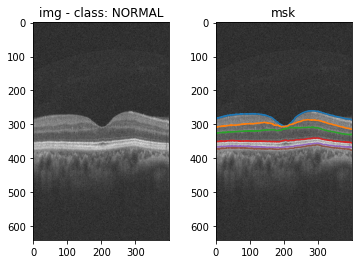

In [75]:
class UnitTestLoss(unittest.TestCase):

    def test_item_labelled(self):
        
        dataloaders = DataLoaderOCTA500(train_kwargs, model_kwargs)        
        
        img, label, msk = next(iter(dataloaders.test_dataloader)) # data.test_dataloader.__getitem__(index=800)

        #print("mask")
        #print(len(msk))
        #print(msk[0])

        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.set_title(f'img - class: {label[0]}')
        ax2.set_title('msk')
        ax1.imshow(img.permute(1, 2, 0), cmap="gray")
        ax2.imshow(img.permute(1, 2, 0), cmap="gray")


        #print(msk[0])
        #print(len(msk[0]))

        for m in msk:
            ax2.plot(m.detach().cpu().numpy()[0])

        
        print(label[0])
        
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

In [70]:
dataloaders = DataLoaderOCTA500(train_kwargs, model_kwargs)        

img, label, msk = next(iter(dataloaders.test_dataloader)) # data.test_dataloader.__getitem__(index=800)




test
        id                                     img_path  \
0    10001  example_data/octa500/imgs_6x6/10001_200.bmp   
1    10002  example_data/octa500/imgs_6x6/10002_200.bmp   
2    10003  example_data/octa500/imgs_6x6/10003_200.bmp   
3    10004  example_data/octa500/imgs_6x6/10004_200.bmp   
4    10005  example_data/octa500/imgs_6x6/10005_200.bmp   
..     ...                                          ...   
295  10296  example_data/octa500/imgs_6x6/10296_200.bmp   
296  10297  example_data/octa500/imgs_6x6/10297_200.bmp   
297  10298  example_data/octa500/imgs_6x6/10298_200.bmp   
298  10299  example_data/octa500/imgs_6x6/10299_200.bmp   
299  10300  example_data/octa500/imgs_6x6/10300_200.bmp   

                                    msk_path  mode lbl_disease sex os-od  age  
0    example_data/octa500/msks_6x6/10001.mat  test      NORMAL   M    OD   55  
1    example_data/octa500/msks_6x6/10002.mat  test      OTHERS   F    OD   37  
2    example_data/octa500/msks_6x6/10003.mat  

AttributeError: 'tuple' object has no attribute 'item'

In [73]:
label[0]

'NORMAL'

In [49]:
m0 = msk[0].detach().cpu().numpy()
len(m0[0])

400

In [45]:
msk[0]

tensor([[283, 282, 282, 281, 282, 281, 281, 280, 281, 280, 280, 279, 280, 279,
         279, 278, 279, 278, 278, 277, 277, 276, 277, 276, 276, 276, 275, 276,
         275, 275, 274, 275, 274, 274, 273, 274, 273, 273, 273, 273, 273, 272,
         273, 272, 272, 272, 272, 272, 271, 272, 271, 271, 272, 271, 271, 271,
         271, 271, 270, 271, 270, 270, 271, 270, 270, 270, 270, 270, 270, 270,
         270, 269, 270, 269, 269, 270, 269, 269, 270, 269, 269, 269, 269, 269,
         269, 269, 269, 269, 269, 270, 269, 269, 270, 269, 269, 269, 269, 269,
         269, 268, 269, 269, 269, 268, 269, 269, 268, 268, 269, 268, 268, 269,
         269, 268, 269, 269, 268, 269, 269, 269, 269, 269, 269, 269, 269, 270,
         270, 269, 270, 270, 270, 270, 270, 271, 271, 270, 271, 271, 272, 271,
         272, 272, 273, 272, 272, 273, 273, 274, 273, 274, 274, 275, 275, 275,
         275, 276, 277, 277, 277, 277, 278, 278, 279, 279, 279, 280, 281, 282,
         282, 283, 284, 285, 286, 287, 287, 288, 289

In [5]:
a d 

SyntaxError: invalid syntax (645411641.py, line 1)

# Mean teacher

In [ ]:
class UnitTestLoss(unittest.TestCase):

    def test_item_labelled(self):
        
        #csv_filenames = ["../data_prep/mt_data_ichallenge_unlabelled.csv"] 
        #csv_filenames = ["../data_prep/mt_data_ichallenge_non_amd.csv"] 
        #csv_filenames = ["../data_prep/mt_data_ichallenge_amd.csv"] 
        #csv_filenames = ["../data_prep/mt_data_ichallenge_glaucoma.csv"]
        csv_filenames = ["../data_prep/mt_data_plex.csv", "../data_prep/mt_data_ichallenge_amd.csv", "../data_prep/mt_data_cirrus.csv"]
        
        mtd = MeanTeacherTrainDataset(mode="train", image_size=512, csv_filenames=csv_filenames)
        item = mtd.__getitem__(index=800)
        print("item")
        print(item)
    
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.set_title('img')
        ax2.set_title('msk')
        ax1.imshow(item["img"].permute(1, 2, 0), cmap="gray")
        ax2.imshow(item["msk"].permute(1, 2, 0), cmap="gray")
        

        #print("Checks")
        #print(torch.sum(torch.isnan(item["msk"])))
        #print(torch.isnan(item["msk"]))
        #print(item["msk"] != item["msk"]) # math.nan
        #print(item["msk"])
        
    def test_item_unlabelled(self):
        
        #csv_filenames = ["../data_prep/mt_data_ichallenge_unlabelled.csv"] 
        #csv_filenames = ["../data_prep/mt_data_ichallenge_non_amd.csv"] 
        #csv_filenames = ["../data_prep/mt_data_ichallenge_amd.csv"] 
        #csv_filenames = ["../data_prep/mt_data_ichallenge_glaucoma.csv"]
        csv_filenames = ["../data_prep/mt_data_cirrus.csv"]
        
        mtd = MeanTeacherTrainDataset(mode="train", image_size=512, csv_filenames=csv_filenames)
        item = mtd.__getitem__(index=300)
        print("item")
        print(item)
    
        fig, (ax1, ax2) = plt.subplots(1, 2)
        
        ax1.set_title('img')
        ax2.set_title('msk')
        ax1.imshow(item["img"].permute(1, 2, 0), cmap="gray")
        ax2.imshow(item["msk"].permute(1, 2, 0), cmap="gray")
        
        #print("Checks")
        #print(torch.sum(torch.isnan(item["msk"])))
        #print(torch.isnan(item["msk"]))
        #print(item["msk"] != item["msk"]) # math.nan
        #print(item["msk"])

In [ ]:
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

In [ ]:
from dataset.transform.image2image import *

In [ ]:
tgt_paths = glob.glob("E:/Christina/Result_Data/CIRRUS_Glaucoma/enface/*_cube_z.tif")
import torchvision.transforms
f = [FourierDomainAdapTransform(tgt_paths=tgt_paths)]
f = torchvision.transforms.Compose(f)

In [ ]:
import glob

from skimage import img_as_ubyte

image_paths = glob.glob("E:/Christina/Result_Data/ADAM_AMD/fundus/*.jpg"  )

for i, path in enumerate( image_paths):
    
    try:
        image = skimage.io.imread(path, plugin='tifffile')
    except:
        image = skimage.io.imread(path, as_gray=True)
        image = img_as_ubyte(image)
    
    item = f({"img" : image, "has_mask" : True})
    
    
    
    image = item["img"]
    
    #print(image.shape)
    
    p = f"E:/Christina/Result_Data/FDA_Fundus_2_CIRRUS/fda_fundus_to_cirrus{i}.jpg"
    #print(p)
    skimage.io.imsave(p, image)